In [1]:
%matplotlib inline


The next challenge is in traces pre-alignment before processing (inconsistencies in sampling time intervals and so on). So we will introduce few new functions to deal with that complication via sum of absolute differences

As always, at first we shall start with basic inputs/constants/loads

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Sbox = (
0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16)


textIn = np.load('textin.npy', allow_pickle=False)
traces = np.load('traces.npy', allow_pickle=False)

In [3]:
def align(traces):    # main SOAD method alighnment implementation
    windowStart = 1500
    windowEnd = 1900
    windowLen = 400
    rangeStart = 0
    rangeEnd = 5000
    refTrace = traces[0]                                        # reference trace
    ctrlWindow = np.array(refTrace[windowStart: windowEnd])     # control window
    offsets = []
    for i in range(1, len(traces)):
        diffs = []
        curTrace = traces[i]
        for j in range(rangeStart, rangeEnd - windowLen):
            curWindow = np.array(curTrace[j: j + windowLen])
            curDif = sum(abs(ctrlWindow - curWindow))
            diffs.append(curDif)
        minIndx = np.array(diffs).argmin()
        offsets.append(minIndx + rangeStart - windowStart)      # offset to the left
    return offsets

In [4]:
def applyOffset(offsets, traces):
    resTraces = [traces[0]]
    for i in range(1, len(traces)):
        curTrace = traces[i]
        of = offsets[i - 1]
        if of >= 0:
            newTrace = list(curTrace[of:]) + [0] * of
        else:
            newTrace = [0] * abs(of) + list(curTrace[:of])  # offset is negative, so a[:offset] is well enough
        resTraces.append(np.array(newTrace))
    np.save('alignedTraces', np.array(resTraces))
    return resTraces


Let's take a look at result

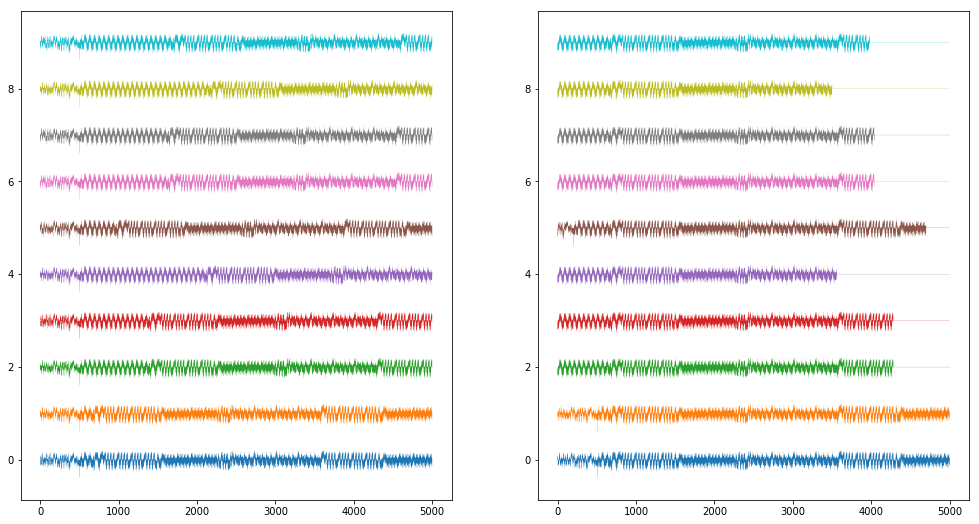

In [15]:
alignedTraces = np.load('alignedTraces.npy', allow_pickle=False)

plt.subplot(1, 2, 1)
fig = plt.gcf()
fig.set_size_inches(17, 9)
for i in range(10):
    plt.plot(traces[i] + i, linewidth=0.2)

plt.subplot(1, 2, 2)
for i in range(10):
    plt.plot(alignedTraces[i] + i, linewidth=0.2)
    
plt.show()

And now, some usual routine

In [5]:
def cor(x, y):
    return np.corrcoef(x, y)[1, 0]


def hamming(x):
    b = bin(x)[2:]
    res = b.count('1')
    return res


def getPrediction(textIn, byteNum, byteVal):
    prediction = np.zeros(len(textIn))
    for i in range(len(textIn)):
        prediction[i] = hamming(Sbox[textIn[i][byteNum] ^ byteVal])
    return prediction


def guessKey(textIn, traces):
    key = np.zeros(16)
    for byte_num in range(16):
        tmpRes = [0 for i in range(256)]
        for byte_val in range(256):
            print(byte_val)
            mxVal = 0
            mxIndx = None
            prediction = getPrediction(textIn, byte_num, byte_val)
            for i, sample in enumerate(zip(*traces)):
                correlation = cor(prediction, sample)
                if abs(correlation) > mxVal:
                    mxVal = abs(correlation)
                    mxIndx = i
            tmpRes[byte_val] = (mxVal, mxIndx)
        b = max(enumerate(tmpRes), key=lambda x: x[1][0])
        # key[byte_num]
        msg = 'byte number: {}\n byte value:{}\n correlation value:{}\n leakage place:{}\n\n\n'
        print(msg.format(byte_num, b[0], b[1][0], b[1][1]))
        key[byte_num] = b[0]
    return key

In [6]:
key = [ 49, 105,  86, 101,  32,  89,  48, 117, 124,  50,  32,  68, 114,  51, 64,  77]
print(bytes(key))

b'1iVe Y0u|2 Dr3@M'
